In [3]:
# https://gluon.mxnet.io/chapter03_deep-neural-networks/mlp-gluon.html#Faster-modeling-with-gluon.nn.Sequential
%matplotlib inline

from __future__ import print_function
from time import time
from IPython.display import clear_output
import csv
import numpy as np
import matplotlib.pyplot as plt
import mxnet as mx
from mxnet import nd, autograd, gluon

X = []
y = []
# with open('snapshots_Xy_180723_141339.csv', 'rb') as f:
with open('snapshots_Xy_180810_114422.csv', 'rb') as f:
    rdr = csv.reader(f, delimiter=',')
    next(rdr)
    # dat = [r for r in rdr]
    for row in rdr:
        X.append([float(x) for x in row[1:-1]])
        y.append(int(row[1]))

X = nd.array(X)
y = nd.array(y)

mx.random.seed(122)

sel = nd.random.shuffle(nd.arange(X.shape[0]))
X = X[sel,:]
y = y[sel]




num_of_samples, num_of_feats = X.shape
num_of_samples = int(0.7 * num_of_samples)
batch_size = int(num_of_samples / 1)

Xtrain = X[0:num_of_samples,:]
ytrain = y[0:num_of_samples]
Xtest = X[num_of_samples:,:]
ytest = y[num_of_samples:]

print(' NUMBER OF FEATURES - %4d' %num_of_feats)
print('   TRAINING DATASET - SECURE: %4d | INSECURE: %4d' 
      %(sum(ytrain==1).asscalar(), sum(ytrain==0).asscalar()))
print('    TESTING DATASET - SECURE: %4d | INSECURE: %4d' 
      %(sum(ytest==1).asscalar(), sum(ytest==0).asscalar()))

train_data = gluon.data.DataLoader(gluon.data.ArrayDataset(Xtrain, ytrain),
                                   batch_size=batch_size, shuffle=False)
test_data = gluon.data.DataLoader(gluon.data.ArrayDataset(Xtest, ytest),
                                  batch_size=batch_size, shuffle=False)

mdl_ctx = mx.gpu()
dat_ctx = mx.gpu()
softmax_cross_entropy = gluon.loss.SoftmaxCrossEntropyLoss()


def evaluate_accuracy(data_iterator, net):
    acc = mx.metric.Accuracy()
    for i, (data, label) in enumerate(data_iterator):
        data = data.as_in_context(mdl_ctx).reshape((-1, num_of_feats))
        label = label.as_in_context(mdl_ctx)
        output = net(data)
        predictions = nd.argmax(output, axis=1)
        acc.update(preds=predictions, labels=label)
    return acc.get()[1]

def movavg(data, window_width):
    cumsum_vec = np.cumsum(np.insert(data, 0, 0)) 
    ma_vec = (cumsum_vec[window_width:] - cumsum_vec[:-window_width]) / window_width
    return ma_vec


 NUMBER OF FEATURES -  525
   TRAINING DATASET - SECURE: 1707 | INSECURE: 1093
    TESTING DATASET - SECURE:  735 | INSECURE:  465


In [4]:
def nntrain(algo, epochs, param):
    train_acc = []
    test_acc = []
    epo_time = []
    epo_loss = []
    cum_time = 0.
    
    net = gluon.nn.Sequential()
    with net.name_scope():
        net.add(gluon.nn.Dense(512, activation="relu"))
        net.add(gluon.nn.Dense(256, activation="relu"))
        net.add(gluon.nn.Dense(128, activation="relu"))
#         net.add(gluon.nn.Dense(64, activation="relu"))
        net.add(gluon.nn.Dense(64))

    net.collect_params().initialize(mx.init.Normal(sigma=.1), ctx=mdl_ctx)
    trainer = gluon.Trainer(net.collect_params(), algo, param)

    for e in range(epochs):
        tic = time()
        cumulative_loss = 0
        for i, (data, label) in enumerate(train_data):
            data = data.as_in_context(mdl_ctx).reshape((-1, num_of_feats))
            label = label.as_in_context(mdl_ctx)
            with autograd.record():
                output = net(data)
                loss = softmax_cross_entropy(output, label)
            loss.backward()
            trainer.step(data.shape[0])
            cumulative_loss += nd.sum(loss).asscalar()

        train_acc.append(evaluate_accuracy(train_data, net))
        test_acc.append(evaluate_accuracy(test_data, net))
        epo_time.append(time() - tic)
        cum_time += time() - tic
        epo_loss.append(cumulative_loss/num_of_samples)
        
        clear_output(wait=True)
        print("Epoch #%4d. Train_acc: %9.8f, Test_acc: %9.8f, Time: %9.8f, Loss: %12.8f" %
              (e+1, train_acc[e], test_acc[e], epo_time[e], epo_loss[e]))        
    
    print("    >>> Completed! Training time: %9.8f" %cum_time)
    for i in range(epochs/500):
        idx = 500 * (i+1)
        print('With %4d Epochs: train_acc: %9.8f, test_acc: %9.8f, loss: %9.8f, cum_time: %8.4fs' 
              %(idx, train_acc[idx-1], test_acc[idx-1], epo_loss[idx-1], sum(epo_time[0:idx-1])))
    
    print('Preset Learning Rate: %s' %trainer._optimizer._get_lr(-1))
    return train_acc, test_acc, epo_time, epo_loss, cum_time    

In [5]:
ma = 50
num_of_epochs = ma + 4000
nonadarate = 2e-5
adarate = 2e-4

In [6]:
# **************** SGD ****************
sgd_train_acc, sgd_test_acc, sgd_epo_time, sgd_epo_loss, sgd_cum_time = nntrain('sgd', num_of_epochs, 
                                                                                {'learning_rate': nonadarate})

Epoch #4050. Train_acc: 0.94535714, Test_acc: 0.95416667, Time: 0.12236309, Loss:   0.12558855
    >>> Completed! Training time: 539.90954232
With  500 Epochs: train_acc: 0.90535714, test_acc: 0.90416667, loss: 0.22668213, cum_time:  67.1881s
With 1000 Epochs: train_acc: 0.91500000, test_acc: 0.92416667, loss: 0.19403774, cum_time: 133.8397s
With 1500 Epochs: train_acc: 0.91464286, test_acc: 0.92416667, loss: 0.19317285, cum_time: 200.3536s
With 2000 Epochs: train_acc: 0.91714286, test_acc: 0.93000000, loss: 0.18549781, cum_time: 266.8075s
With 2500 Epochs: train_acc: 0.92571429, test_acc: 0.93500000, loss: 0.16753043, cum_time: 333.3205s
With 3000 Epochs: train_acc: 0.92857143, test_acc: 0.93666667, loss: 0.16396137, cum_time: 399.7782s
With 3500 Epochs: train_acc: 0.93142857, test_acc: 0.94083333, loss: 0.15346052, cum_time: 466.3600s
With 4000 Epochs: train_acc: 0.92000000, test_acc: 0.92916667, loss: 0.18913400, cum_time: 533.0890s
Preset Learning Rate: 2e-05


In [7]:
# **************** SGD-M ****************
sgdm_train_acc, sgdm_test_acc, sgdm_epo_time, sgdm_epo_loss, sgdm_cum_time = nntrain('sgd', num_of_epochs, 
                                                                                {'learning_rate': nonadarate,
                                                                                 'momentum': 0.009})

Epoch #4050. Train_acc: 0.82571429, Test_acc: 0.80166667, Time: 0.13616204, Loss:   0.47888436
    >>> Completed! Training time: 570.51432395
With  500 Epochs: train_acc: 0.90714286, test_acc: 0.91333333, loss: 0.21752760, cum_time:  70.6912s
With 1000 Epochs: train_acc: 0.93142857, test_acc: 0.93500000, loss: 0.15162404, cum_time: 141.3569s
With 1500 Epochs: train_acc: 0.87214286, test_acc: 0.86000000, loss: 0.29622916, cum_time: 211.8143s
With 2000 Epochs: train_acc: 0.92464286, test_acc: 0.92166667, loss: 0.16156345, cum_time: 282.1403s
With 2500 Epochs: train_acc: 0.95178571, test_acc: 0.96166667, loss: 0.11332339, cum_time: 352.4628s
With 3000 Epochs: train_acc: 0.95285714, test_acc: 0.96000000, loss: 0.10939866, cum_time: 422.7404s
With 3500 Epochs: train_acc: 0.95321429, test_acc: 0.96416667, loss: 0.10706140, cum_time: 493.1625s
With 4000 Epochs: train_acc: 0.95214286, test_acc: 0.96500000, loss: 0.10541217, cum_time: 563.3686s
Preset Learning Rate: 2e-05


In [8]:
# **************** NAG ****************
nag_train_acc, nag_test_acc, nag_epo_time, nag_epo_loss, nag_cum_time = nntrain('nag', num_of_epochs, 
                                                                                {'learning_rate': nonadarate,
                                                                                 'momentum': 0.})

Epoch #4050. Train_acc: 0.95107143, Test_acc: 0.95416667, Time: 0.12179112, Loss:   0.11360458
    >>> Completed! Training time: 538.08503747
With  500 Epochs: train_acc: 0.93535714, test_acc: 0.94500000, loss: 0.14742281, cum_time:  66.2341s
With 1000 Epochs: train_acc: 0.94357143, test_acc: 0.95000000, loss: 0.12976885, cum_time: 132.5733s
With 1500 Epochs: train_acc: 0.94535714, test_acc: 0.95416667, loss: 0.12149049, cum_time: 199.0522s
With 2000 Epochs: train_acc: 0.94642857, test_acc: 0.94916667, loss: 0.12163021, cum_time: 265.3782s
With 2500 Epochs: train_acc: 0.94678571, test_acc: 0.94666667, loss: 0.12104970, cum_time: 331.7152s
With 3000 Epochs: train_acc: 0.94892857, test_acc: 0.94666667, loss: 0.12011396, cum_time: 398.1306s
With 3500 Epochs: train_acc: 0.95107143, test_acc: 0.95416667, loss: 0.11194275, cum_time: 464.7413s
With 4000 Epochs: train_acc: 0.95107143, test_acc: 0.95250000, loss: 0.11324128, cum_time: 531.2957s
Preset Learning Rate: 2e-05


In [9]:
# **************** NAG-M ****************
nagm_train_acc, nagm_test_acc, nagm_epo_time, nagm_epo_loss, nagm_cum_time = nntrain('nag', num_of_epochs, 
                                                                                {'learning_rate': nonadarate,
                                                                                 'momentum': 0.009})

Epoch #4050. Train_acc: 0.93821429, Test_acc: 0.93000000, Time: 0.12060022, Loss:   0.14042985
    >>> Completed! Training time: 539.84770942
With  500 Epochs: train_acc: 0.85964286, test_acc: 0.85333333, loss: 0.32583644, cum_time:  66.5292s
With 1000 Epochs: train_acc: 0.88107143, test_acc: 0.87916667, loss: 0.27688592, cum_time: 133.1440s
With 1500 Epochs: train_acc: 0.91464286, test_acc: 0.90583333, loss: 0.19747266, cum_time: 199.7581s
With 2000 Epochs: train_acc: 0.92785714, test_acc: 0.92000000, loss: 0.16987645, cum_time: 266.3432s
With 2500 Epochs: train_acc: 0.92857143, test_acc: 0.92166667, loss: 0.16300866, cum_time: 333.1066s
With 3000 Epochs: train_acc: 0.93892857, test_acc: 0.92666667, loss: 0.14360408, cum_time: 399.8418s
With 3500 Epochs: train_acc: 0.92964286, test_acc: 0.92833333, loss: 0.15992788, cum_time: 466.5450s
With 4000 Epochs: train_acc: 0.94035714, test_acc: 0.93166667, loss: 0.13543760, cum_time: 533.0858s
Preset Learning Rate: 2e-05


In [10]:
# # **************** TestAlgo ****************
algo_train_acc, algo_test_acc, algo_epo_time, algo_epo_loss, algo_cum_time = nntrain('rmsprop', num_of_epochs, 
                                                                                {'learning_rate': nonadarate})

Epoch #4050. Train_acc: 0.91928571, Test_acc: 0.92666667, Time: 0.16885018, Loss:   7.94073870
    >>> Completed! Training time: 538.93805957
With  500 Epochs: train_acc: 0.78535714, test_acc: 0.78500000, loss: 24.61539621, cum_time:  66.3244s
With 1000 Epochs: train_acc: 0.84428571, test_acc: 0.84500000, loss: 16.73003767, cum_time: 132.8316s
With 1500 Epochs: train_acc: 0.87964286, test_acc: 0.89083333, loss: 8.81723703, cum_time: 199.3713s
With 2000 Epochs: train_acc: 0.91821429, test_acc: 0.92333333, loss: 8.05659319, cum_time: 265.9426s
With 2500 Epochs: train_acc: 0.86535714, test_acc: 0.87333333, loss: 15.91286412, cum_time: 332.2652s
With 3000 Epochs: train_acc: 0.86035714, test_acc: 0.86583333, loss: 17.29305246, cum_time: 398.7834s
With 3500 Epochs: train_acc: 0.82500000, test_acc: 0.83500000, loss: 38.01500000, cum_time: 465.6530s
With 4000 Epochs: train_acc: 0.89785714, test_acc: 0.90750000, loss: 7.54912319, cum_time: 532.1178s
Preset Learning Rate: 2e-05


In [11]:
# **************** AdaGrad ****************
adag_train_acc, adag_test_acc, adag_epo_time, adag_epo_loss, adag_cum_time = nntrain('adagrad', num_of_epochs, 
                                                                                     {'learning_rate': adarate})

Epoch #4050. Train_acc: 0.95535714, Test_acc: 0.95250000, Time: 0.15561414, Loss:   1.27346898
    >>> Completed! Training time: 542.90389991
With  500 Epochs: train_acc: 0.90250000, test_acc: 0.90333333, loss: 5.64579590, cum_time:  66.8636s
With 1000 Epochs: train_acc: 0.91678571, test_acc: 0.92083333, loss: 4.12312988, cum_time: 133.9135s
With 1500 Epochs: train_acc: 0.93071429, test_acc: 0.92750000, loss: 3.32228027, cum_time: 200.9806s
With 2000 Epochs: train_acc: 0.93500000, test_acc: 0.92916667, loss: 2.80063494, cum_time: 268.0991s
With 2500 Epochs: train_acc: 0.93892857, test_acc: 0.93416667, loss: 2.38974261, cum_time: 335.2212s
With 3000 Epochs: train_acc: 0.94250000, test_acc: 0.93833333, loss: 2.03761579, cum_time: 402.0447s
With 3500 Epochs: train_acc: 0.94714286, test_acc: 0.94750000, loss: 1.60281390, cum_time: 469.0735s
With 4000 Epochs: train_acc: 0.95392857, test_acc: 0.94833333, loss: 1.27920672, cum_time: 536.0632s
Preset Learning Rate: 0.0002


In [12]:
# **************** ADAM ****************
adam_train_acc, adam_test_acc, adam_epo_time, adam_epo_loss, adam_cum_time = nntrain('adam', num_of_epochs, 
                                                                                     {'learning_rate': adarate})

Epoch #4050. Train_acc: 0.98678571, Test_acc: 0.98333333, Time: 0.13226700, Loss:   0.12990546
    >>> Completed! Training time: 594.59658051
With  500 Epochs: train_acc: 0.94000000, test_acc: 0.94333333, loss: 1.60136579, cum_time:  71.5577s
With 1000 Epochs: train_acc: 0.97250000, test_acc: 0.97666667, loss: 0.70923226, cum_time: 143.0653s
With 1500 Epochs: train_acc: 0.98571429, test_acc: 0.98500000, loss: 0.17983756, cum_time: 214.9034s
With 2000 Epochs: train_acc: 0.98571429, test_acc: 0.98666667, loss: 0.14456991, cum_time: 286.2719s
With 2500 Epochs: train_acc: 0.99071429, test_acc: 0.99083333, loss: 0.09754398, cum_time: 357.5271s
With 3000 Epochs: train_acc: 0.98821429, test_acc: 0.99250000, loss: 0.11808775, cum_time: 428.8290s
With 3500 Epochs: train_acc: 0.94857143, test_acc: 0.94500000, loss: 0.86565055, cum_time: 501.0253s
With 4000 Epochs: train_acc: 0.98750000, test_acc: 0.98666667, loss: 0.10636040, cum_time: 586.2340s
Preset Learning Rate: 0.0002


In [13]:
# **************** NADAM ****************
nadam_train_acc, nadam_test_acc, nadam_epo_time, nadam_epo_loss, nadam_cum_time = nntrain('nadam', num_of_epochs, 
                                                                                          {'learning_rate': adarate})

Epoch #4050. Train_acc: 0.97607143, Test_acc: 0.98583333, Time: 0.14260817, Loss:   0.67045462
    >>> Completed! Training time: 619.23141456
With  500 Epochs: train_acc: 0.92857143, test_acc: 0.93583333, loss: 5.75083636, cum_time:  69.7741s
With 1000 Epochs: train_acc: 0.95178571, test_acc: 0.96250000, loss: 3.00578090, cum_time: 150.5594s
With 1500 Epochs: train_acc: 0.95892857, test_acc: 0.97250000, loss: 2.46192453, cum_time: 219.8576s
With 2000 Epochs: train_acc: 0.96321429, test_acc: 0.97333333, loss: 2.07195033, cum_time: 287.4581s
With 2500 Epochs: train_acc: 0.96500000, test_acc: 0.97416667, loss: 1.54241699, cum_time: 366.0220s
With 3000 Epochs: train_acc: 0.94357143, test_acc: 0.94416667, loss: 3.18741595, cum_time: 447.4517s
With 3500 Epochs: train_acc: 0.94250000, test_acc: 0.94500000, loss: 3.14072684, cum_time: 528.7673s
With 4000 Epochs: train_acc: 0.97250000, test_acc: 0.98500000, loss: 0.90170027, cum_time: 610.7878s
Preset Learning Rate: 0.0002


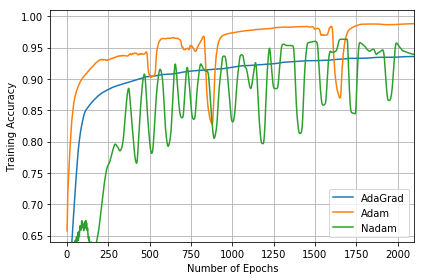

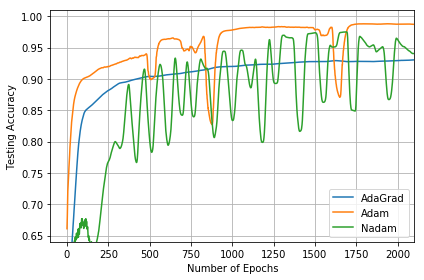

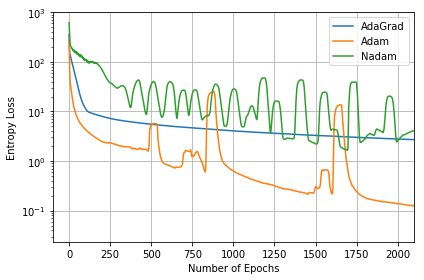

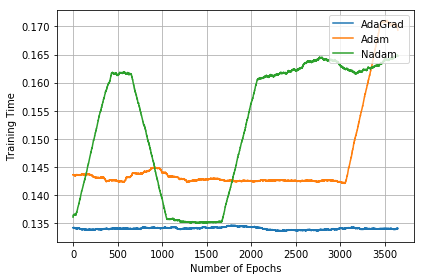

In [14]:
fig_train_acc, axs = plt.subplots()
axs.grid(True)
axs.plot(movavg(adag_train_acc, ma))
axs.plot(movavg(adam_train_acc, ma))
axs.plot(movavg(nadam_train_acc, ma))
# axs.plot(movavg(algo_train_acc, ma))
plt.legend(['AdaGrad', 'Adam', 'Nadam'], loc='lower right')
plt.xlabel('Number of Epochs')
plt.ylabel('Training Accuracy')
plt.ylim([0.64, 1.01])
plt.xlim([-100, 2100])
fig_train_acc.tight_layout()
fig_train_acc.savefig('train_acc_ada.eps', format='eps')

fig_test_acc, axs = plt.subplots()
axs.grid(True)
axs.plot(movavg(adag_test_acc, ma))
axs.plot(movavg(adam_test_acc, ma))
axs.plot(movavg(nadam_test_acc, ma))
# axs.plot(movavg(algo_test_acc, ma))
plt.legend(['AdaGrad', 'Adam', 'Nadam'], loc='lower right')
plt.xlabel('Number of Epochs')
plt.ylabel('Testing Accuracy')
plt.ylim([0.64, 1.01])
plt.xlim([-100, 2100])
fig_test_acc.tight_layout()
fig_test_acc.savefig('test_acc_ada.eps', format='eps')

fig_loss_err, ax1 = plt.subplots()
ax1.set_xlabel('Number of Epochs')
ax1.set_ylabel('Entropy Loss')
ax1.plot(movavg(adag_epo_loss,ma))
ax1.plot(movavg(adam_epo_loss,ma))
ax1.plot(movavg(nadam_epo_loss,ma))
# ax1.plot(movavg(algo_epo_loss,ma))
ax1.set_yscale("log", nonposy='clip')
plt.legend(['AdaGrad', 'Adam', 'Nadam'], loc='upper right')
plt.xlim([-100, 2100])
# plt.ylim([0.5e-4, 1.5e3])

# ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
# ax2.set_ylabel('Error')  # we already handled the x-label with ax1
# ax2.plot(1-np.asarray(train_acc), color='tab:blue')
# ax2.plot(1-np.asarray(test_acc), color='tab:orange')
# plt.legend(['train', 'test'], loc='upper right')
plt.grid(True)
fig_loss_err.tight_layout()  # otherwise the right y-label is slightly clipped
fig_loss_err.savefig('loss_err_ada.eps', format='eps')

fig_time, ax1 = plt.subplots()
plt.grid(True)
ax1.plot(movavg(adag_epo_time,400))
ax1.plot(movavg(adam_epo_time,400))
ax1.plot(movavg(nadam_epo_time,400))
plt.legend(['AdaGrad', 'Adam', 'Nadam'], loc='upper right')
plt.xlabel('Number of Epochs')
plt.ylabel('Training Time')
fig_time.tight_layout()
fig_time.savefig('time_ada.eps', format='eps')



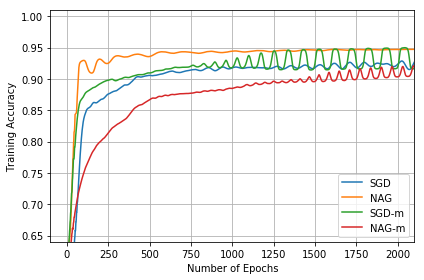

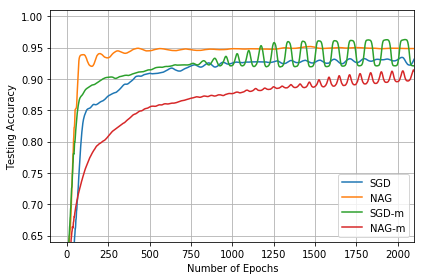

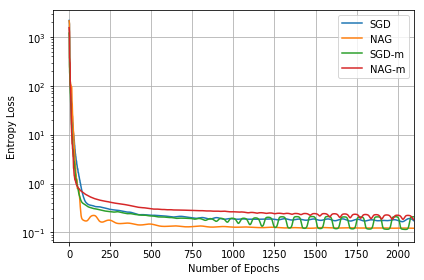

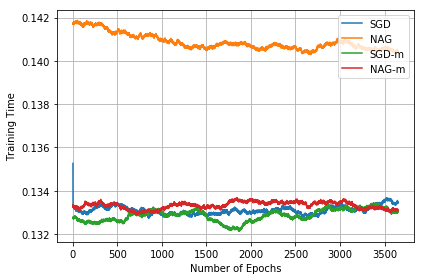

In [15]:
fig_train_acc, axs = plt.subplots()
axs.grid(True)
axs.plot(movavg(sgd_train_acc, ma))
axs.plot(movavg(nag_train_acc, ma))
axs.plot(movavg(sgdm_train_acc, ma))
axs.plot(movavg(nagm_train_acc, ma))
plt.legend(['SGD', 'NAG', 'SGD-m', 'NAG-m'], loc='lower right')
plt.xlabel('Number of Epochs')
plt.ylabel('Training Accuracy')
plt.ylim([0.64, 1.01])
plt.xlim([-100, 2100])
fig_train_acc.tight_layout()
fig_train_acc.savefig('train_acc_nonada.eps', format='eps')

fig_test_acc, axs = plt.subplots()
axs.grid(True)
axs.plot(movavg(sgd_test_acc, ma))
axs.plot(movavg(nag_test_acc, ma))
axs.plot(movavg(sgdm_test_acc, ma))
axs.plot(movavg(nagm_test_acc, ma))
plt.legend(['SGD', 'NAG', 'SGD-m', 'NAG-m'], loc='lower right')
plt.xlabel('Number of Epochs')
plt.ylabel('Testing Accuracy')
plt.ylim([0.64, 1.01])
plt.xlim([-100, 2100])
fig_test_acc.tight_layout()
fig_test_acc.savefig('test_acc_nonada.eps', format='eps')

fig_loss_err, ax1 = plt.subplots()
ax1.set_xlabel('Number of Epochs')
ax1.set_ylabel('Entropy Loss')
ax1.plot(movavg(sgd_epo_loss,ma))
ax1.plot(movavg(nag_epo_loss,ma))
ax1.plot(movavg(sgdm_epo_loss,ma))
ax1.plot(movavg(nagm_epo_loss,ma))
ax1.set_yscale("log", nonposy='clip')
plt.legend(['SGD', 'NAG', 'SGD-m', 'NAG-m'], loc='upper right')
plt.xlim([-100, 2100])
# plt.ylim([0.5e-1, 1.5e3])

# ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
# ax2.set_ylabel('Error')  # we already handled the x-label with ax1
# ax2.plot(1-np.asarray(train_acc), color='tab:blue')
# ax2.plot(1-np.asarray(test_acc), color='tab:orange')
# plt.legend(['train', 'test'], loc='upper right')
plt.grid(True)
fig_loss_err.tight_layout()  # otherwise the right y-label is slightly clipped
fig_loss_err.savefig('loss_err_nonada.eps', format='eps')

fig_time, ax1 = plt.subplots()
plt.grid(True)
ax1.plot(movavg(sgd_epo_time,400))
ax1.plot(movavg(sgdm_epo_time,400))
ax1.plot(movavg(nag_epo_time,400))
ax1.plot(movavg(nagm_epo_time,400))
plt.xlabel('Number of Epochs')
plt.ylabel('Training Time')
plt.legend(['SGD', 'NAG', 'SGD-m', 'NAG-m'], loc='upper right')
fig_time.tight_layout()
fig_time.savefig('time_nonada.eps', format='eps')

